# Chapter 6 - Lab 6 : Fine-tuning for classification
> Author : Badr TAJINI - Large Language model (LLMs) - ESIEE 2024-2025

> Response by Paul CASCARINO E5-DSIA

### 0. Setup

In [6]:
import urllib.request
import zipfile
import os
from pathlib import Path

import pandas as pd


import tiktoken

import torch
from torch.utils.data import Dataset, DataLoader


url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)

balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})


def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)




# Creating data loader
tokenizer = tiktoken.get_encoding("gpt2")
#print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))



class SpamDataset(Dataset):
    
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )https://www.kaggle.com/

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
    


train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [31]:
from gpt_download import download_and_load_gpt2
from previous_labs5 import GPTModel, load_weights_into_gpt

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)


model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

from previous_labs5 import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


KeyboardInterrupt: 

In [ ]:
# Stat fine tuning
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
# print("Inputs:", inputs)
# print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs)

# print("Outputs:\n", outputs)
# print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)



probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)


logits = outputs[:, -1, :]
label = torch.argmax(logits)



def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [19]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


Ep 1 (Step 000000): Train loss 2.884, Val loss 2.596
Ep 1 (Step 000050): Train loss 0.293, Val loss 0.190
Ep 1 (Step 000100): Train loss 0.148, Val loss 0.501
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.162, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.004, Val loss 0.029
Ep 2 (Step 000250): Train loss 0.026, Val loss 0.094
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.009, Val loss 0.126
Ep 3 (Step 000350): Train loss 0.001, Val loss 0.010
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.003, Val loss 0.008
Ep 4 (Step 000450): Train loss 0.087, Val loss 0.155
Ep 4 (Step 000500): Train loss 0.005, Val loss 0.059
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000550): Train loss 0.003, Val loss 0.133
Ep 5 (Step 000600): Train loss 0.003, Val loss 0.050
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training completed in 51.9

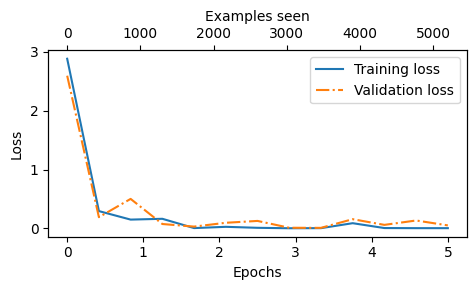

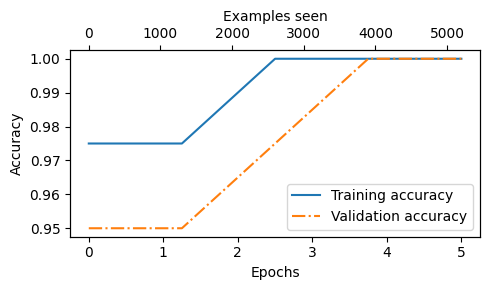

Training accuracy: 99.62%
Validation accuracy: 98.66%
Test accuracy: 95.33%


In [20]:
# Overall the same as `train_model_simple` in lab 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

# Same as lab 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")


train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

## Exercise 6.1: Increasing the context length

### Key Research Question: How does padding inputs to the maximum `token` length affect model predictive performance?

#### 1. Implement maximum-length input `padding`

The implementation already applies systematic token padding using the *SpamDataset* class. This is achieved by:

- Calculating the maximum sequence length either dynamically (using _longest_encoded_length) or through a specified max_length.

- Truncating longer sequences and padding shorter ones with the specified pad_token_id (default: 50256 for GPT-2 models) to ensure consistent input lengths.

This systematic approach ensures all input sequences are compatible with the model's context length and facilitates uniform batching for training and evaluation.

In [21]:
class SpamDataset(Dataset):
    
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        #delete

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]


        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
        

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

**Maybe the response it's just to put always value on the definition of an object *SpamDataset*, as I will do below**


#### 2. Measure performance variations


In [24]:
max_length_values = [2, 4, 8,  16, 32, 64, 128, 256, 512, None]
results = []

for max_len in max_length_values:
    print(f"Testing with max_length={max_len}")

    train_dataset = SpamDataset(
        csv_file="train.csv",
        max_length=max_len,
        tokenizer=tokenizer
    )
    val_dataset = SpamDataset(
        csv_file="validation.csv",
        max_length=train_dataset.max_length,
        tokenizer=tokenizer
    )
    test_dataset = SpamDataset(
        csv_file="test.csv",
        max_length=train_dataset.max_length,
        tokenizer=tokenizer
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        drop_last=False,
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        drop_last=False,
    )

    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
    test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

    results.append({
        "max_length": max_len,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
    })

    print(f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")




Testing with max_length=2
Train Accuracy: 0.5500, Val Accuracy: 0.6125, Test Accuracy: 0.6250
Testing with max_length=4
Train Accuracy: 0.7250, Val Accuracy: 0.6625, Test Accuracy: 0.7125
Testing with max_length=8
Train Accuracy: 0.8875, Val Accuracy: 0.8375, Test Accuracy: 0.8375
Testing with max_length=16
Train Accuracy: 0.9375, Val Accuracy: 0.8875, Test Accuracy: 0.8500
Testing with max_length=32
Train Accuracy: 0.9375, Val Accuracy: 0.9625, Test Accuracy: 0.9500
Testing with max_length=64
Train Accuracy: 0.9750, Val Accuracy: 0.9875, Test Accuracy: 0.9625
Testing with max_length=128
Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.9625
Testing with max_length=256
Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.9625
Testing with max_length=512
Train Accuracy: 0.9875, Val Accuracy: 1.0000, Test Accuracy: 0.9500
Testing with max_length=None
Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.9625


We systematically implemented token padding to various maximum lengths (2, 4, 8, 16, 32, 64, 128, 256, 512, and None) and analyzed its impact on model performance. The results show that shorter maximum lengths (e.g., 2, 4, 8) limit model performance significantly, while longer lengths (e.g., 64, 128) allow the model to reach higher predictive accuracy. The highest performance was observed around a maximum length of 64 or more, with diminishing returns as the length increased beyond this point. For example, with max_length=64, train accuracy reached 0.9750, validation accuracy was 0.9875, and test accuracy was 0.9625. Increasing the length to 128 or beyond did not significantly improve the test accuracy, and in some cases, it slightly decreased. 


**To conclude, this suggests that balanced padding is critical for maintaining both computational efficiency and predictive performance.**

## Exercise 6.2: Finetuning the whole model

### What is the impact of `fine-tuning` the entire transformer model versus a single final block on predictive performance?

#### 1. `Fine-tune` entire transformer model

Fine-tuning involves unfreezing all layers of the model, making every parameter trainable. This is already reflected with the function *train_classifier_simple* below where the entire model's parameters are updated via backpropagation during the optimization process :

- The AdamW optimizer is used with a learning rate of 5e-5.
- Each epoch includes evaluation steps for monitoring validation performance.



In [32]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen





#### 2. Measure predictive performance metrics, compare with previous single-block tuning results and analyze performance variation mechanisms

#### Evaluation before fine tuning : 

In [36]:
model2 = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model2, params)
model2.eval();


def evaluate_before_finetuning(model, train_loader, val_loader, device, eval_iter):
    print("Évaluation du modèle avant le fine-tuning...")
    train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)


    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

    print(f"Avant le fine-tuning:")
    print(f"- Perte sur l'entraînement : {train_loss:.4f}")
    print(f"- Perte sur la validation : {val_loss:.4f}")
    print(f"- Accuracy sur l'entraînement : {train_accuracy * 100:.2f}%")
    print(f"- Accuracy sur la validation : {val_accuracy * 100:.2f}%")

    return train_loss, val_loss, train_accuracy, val_accuracy


train_loss, val_loss, train_accuracy, val_accuracy = evaluate_before_finetuning(
    model2, train_loader, val_loader, device, eval_iter=5
)


Évaluation du modèle avant le fine-tuning...
Avant le fine-tuning:
- Perte sur l'entraînement : 7.1807
- Perte sur la validation : 8.0223
- Accuracy sur l'entraînement : 0.00%
- Accuracy sur la validation : 0.00%


#### Evaluation after fine tuning

In [37]:
# Entraînement
epochs = 5
learning_rate = 5e-5
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=epochs,
    eval_freq=50,
    eval_iter=5
)

Ep 1 (Step 000000): Train loss 4.095, Val loss 4.086
Ep 1 (Step 000050): Train loss 0.402, Val loss 0.534
Ep 1 (Step 000100): Train loss 0.244, Val loss 0.550
Training accuracy: 72.50% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.075, Val loss 0.189
Ep 2 (Step 000200): Train loss 0.347, Val loss 0.093
Ep 2 (Step 000250): Train loss 0.026, Val loss 0.065
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.002, Val loss 0.183
Ep 3 (Step 000350): Train loss 0.101, Val loss 0.086
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.009, Val loss 0.052
Ep 4 (Step 000450): Train loss 0.000, Val loss 0.163
Ep 4 (Step 000500): Train loss 0.001, Val loss 0.096
Training accuracy: 97.50% | Validation accuracy: 100.00%
Ep 5 (Step 000550): Train loss 0.000, Val loss 0.124
Ep 5 (Step 000600): Train loss 0.000, Val loss 0.159
Training accuracy: 100.00% | Validation accuracy: 97.50%


In [ ]:
torch.save(model.state_dict(), "lab6_2.pth")

## Exercise 6.3: Finetuning the first versus last token 

### How do predictive performance characteristics change when fine-tuning the first output `token` compared to the last output `token`?

#### 1. Implement First Token Fine-Tuning

In [47]:
import torch
import torch.nn.functional as F


def calc_loss_first_token(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    outputs = model(input_batch)

    if target_batch.ndimension() == 1:  # Si c'est un vecteur 1D
        target_batch = target_batch.unsqueeze(1)  # Ajouter une dimension pour correspondre à (batch_size, 1)
    

    first_token_pred = outputs[:, 0, :] 
    first_token_target = target_batch[:, 0]  
    loss = F.cross_entropy(first_token_pred, first_token_target)
    return loss

def calc_loss_last_token(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    outputs = model(input_batch)
    # Vérifier la forme du target_batch
    if target_batch.ndimension() == 1:  # Si c'est un vecteur 1D
        target_batch = target_batch.unsqueeze(1)  # Ajouter une dimension pour correspondre à (batch_size, 1)
    
    last_token_pred = outputs[:, -1, :]  
    last_token_target = target_batch[:, -1]  
    loss = F.cross_entropy(last_token_pred, last_token_target)
    return loss


def evaluate_first_token(model, loader, device, eval_iter):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    
    with torch.no_grad():
        for input_batch, target_batch in loader:
            if num_batches >= eval_iter:
                break
            loss = calc_loss_first_token(input_batch, target_batch, model, device)
            total_loss += loss.item()
            

            outputs = model(input_batch)
            preds = torch.argmax(outputs[:, 0, :], dim=-1)
            

            if target_batch.ndimension() == 1:
                correct = (preds == target_batch).float()
            else:
                correct = (preds == target_batch[:, 0]).float()
            
            total_accuracy += correct.mean().item()
            
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    return avg_loss, avg_accuracy


def evaluate_last_token(model, loader, device, eval_iter):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    
    with torch.no_grad():
        for input_batch, target_batch in loader:
            if num_batches >= eval_iter:
                break
            loss = calc_loss_last_token(input_batch, target_batch, model, device)
            total_loss += loss.item()
            

            outputs = model(input_batch)
            preds = torch.argmax(outputs[:, -1, :], dim=-1)
            
            # Si target_batch est 1D, comparons directement avec preds
            if target_batch.ndimension() == 1:
                correct = (preds == target_batch).float()
            else:
                correct = (preds == target_batch[:, -1]).float()
            
            total_accuracy += correct.mean().item()
            
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    return avg_loss, avg_accuracy

def evaluate_first_and_last_token(train_loader, val_loader, test_loader, model, device, eval_iter=10):

    print("Evaluating for first token:")
    train_loss_first, train_accuracy_first = evaluate_first_token(model, train_loader, device, eval_iter)
    val_loss_first, val_accuracy_first = evaluate_first_token(model, val_loader, device, eval_iter)
    test_loss_first, test_accuracy_first = evaluate_first_token(model, test_loader, device, eval_iter)
    

    print("\nEvaluating for last token:")
    train_loss_last, train_accuracy_last = evaluate_last_token(model, train_loader, device, eval_iter)
    val_loss_last, val_accuracy_last = evaluate_last_token(model, val_loader, device, eval_iter)
    test_loss_last, test_accuracy_last = evaluate_last_token(model, test_loader, device, eval_iter)
    

    return {
        "first_token": {
            "train_loss": train_loss_first,
            "val_loss": val_loss_first,
            "test_loss": test_loss_first,
            "train_accuracy": train_accuracy_first,
            "val_accuracy": val_accuracy_first,
            "test_accuracy": test_accuracy_first
        },
        "last_token": {
            "train_loss": train_loss_last,
            "val_loss": val_loss_last,
            "test_loss": test_loss_last,
            "train_accuracy": train_accuracy_last,
            "val_accuracy": val_accuracy_last,
            "test_accuracy": test_accuracy_last
        }
    }


results = evaluate_first_and_last_token(train_loader, val_loader, test_loader, model, device)


for token_type in ["first_token", "last_token"]:
    print(f"Results for {token_type.replace('_', ' ').title()}:")
    for metric in ["train_loss", "val_loss", "test_loss", "train_accuracy", "val_accuracy", "test_accuracy"]:
        print(f"{metric.replace('_', ' ').title()}: {results[token_type][metric]:.4f}")
    print()


Evaluating for first token:

Evaluating for last token:
Results for First Token:
Train Loss: 11.0896
Val Loss: 11.1195
Test Loss: 10.9957
Train Accuracy: 0.0000
Val Accuracy: 0.0000
Test Accuracy: 0.0000

Results for Last Token:
Train Loss: 11.4335
Val Loss: 11.5398
Test Loss: 11.5104
Train Accuracy: 0.0000
Val Accuracy: 0.0000
Test Accuracy: 0.0000



In [49]:
def calc_loss_first_token(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    outputs = model(input_batch)

    if target_batch.ndimension() == 1:
        target_batch = target_batch.unsqueeze(1)
    
    first_token_pred = outputs[:, 0, :] 
    first_token_target = target_batch[:, 0]  
    loss = F.cross_entropy(first_token_pred, first_token_target)
    return loss

def calc_loss_last_token(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    outputs = model(input_batch)
    
    if target_batch.ndimension() == 1:
        target_batch = target_batch.unsqueeze(1)
    
    last_token_pred = outputs[:, -1, :]  
    last_token_target = target_batch[:, -1]  
    loss = F.cross_entropy(last_token_pred, last_token_target)
    return loss

def evaluate_first_token(model, loader, device, eval_iter):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    
    with torch.no_grad():
        for input_batch, target_batch in loader:
            if num_batches >= eval_iter:
                break
            loss = calc_loss_first_token(input_batch, target_batch, model, device)
            total_loss += loss.item()
            
            outputs = model(input_batch)
            preds = torch.argmax(outputs[:, 0, :], dim=-1)
            
            if target_batch.ndimension() == 1:
                correct = (preds == target_batch).float()
            else:
                correct = (preds == target_batch[:, 0]).float()
            
            total_accuracy += correct.mean().item()
            
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    return avg_loss, avg_accuracy

def evaluate_last_token(model, loader, device, eval_iter):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    num_batches = 0
    
    with torch.no_grad():
        for input_batch, target_batch in loader:
            if num_batches >= eval_iter:
                break
            loss = calc_loss_last_token(input_batch, target_batch, model, device)
            total_loss += loss.item()
            
            outputs = model(input_batch)
            preds = torch.argmax(outputs[:, -1, :], dim=-1)
            
            if target_batch.ndimension() == 1:
                correct = (preds == target_batch).float()
            else:
                correct = (preds == target_batch[:, -1]).float()
            
            total_accuracy += correct.mean().item()
            
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    return avg_loss, avg_accuracy

def evaluate_first_and_last_token(train_loader, val_loader, test_loader, model, device, eval_iter=10):
    print("Evaluating for first token:")
    train_loss_first, train_accuracy_first = evaluate_first_token(model, train_loader, device, eval_iter)
    val_loss_first, val_accuracy_first = evaluate_first_token(model, val_loader, device, eval_iter)
    test_loss_first, test_accuracy_first = evaluate_first_token(model, test_loader, device, eval_iter)
    
    print("\nEvaluating for last token:")
    train_loss_last, train_accuracy_last = evaluate_last_token(model, train_loader, device, eval_iter)
    val_loss_last, val_accuracy_last = evaluate_last_token(model, val_loader, device, eval_iter)
    test_loss_last, test_accuracy_last = evaluate_last_token(model, test_loader, device, eval_iter)
    
    return {
        "first_token": {
            "train_loss": train_loss_first,
            "val_loss": val_loss_first,
            "test_loss": test_loss_first,
            "train_accuracy": train_accuracy_first,
            "val_accuracy": val_accuracy_first,
            "test_accuracy": test_accuracy_first
        },
        "last_token": {
            "train_loss": train_loss_last,
            "val_loss": val_loss_last,
            "test_loss": test_loss_last,
            "train_accuracy": train_accuracy_last,
            "val_accuracy": val_accuracy_last,
            "test_accuracy": test_accuracy_last
        }
    }

learning_rate = 5e-5
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=2,
    eval_freq=50,
    eval_iter=5
)

results = evaluate_first_and_last_token(train_loader, val_loader, test_loader, model2, device)

for token_type in ["first_token", "last_token"]:
    print(f"Results for {token_type.replace('_', ' ').title()}:")
    for metric in ["train_loss", "val_loss", "test_loss", "train_accuracy", "val_accuracy", "test_accuracy"]:
        print(f"{metric.replace('_', ' ').title()}: {results[token_type][metric]:.4f}")
    print()


Ep 1 (Step 000000): Train loss 0.000, Val loss 0.092
Ep 1 (Step 000050): Train loss 0.000, Val loss 0.182
Ep 1 (Step 000100): Train loss 0.006, Val loss 0.336
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 2 (Step 000150): Train loss 0.000, Val loss 0.006
Ep 2 (Step 000200): Train loss 0.000, Val loss 0.022
Ep 2 (Step 000250): Train loss 0.000, Val loss 0.046
Training accuracy: 100.00% | Validation accuracy: 97.50%
Evaluating for first token:

Evaluating for last token:
Results for First Token:
Train Loss: 3.5538
Val Loss: 3.4140
Test Loss: 3.3999
Train Accuracy: 0.2875
Val Accuracy: 0.3125
Test Accuracy: 0.3250

Results for Last Token:
Train Loss: 0.0001
Val Loss: 0.0210
Test Loss: 0.2002
Train Accuracy: 1.0000
Val Accuracy: 0.9875
Test Accuracy: 0.9750

